In [1]:
#@title Prepare the running enviroment
%cd /content
!git clone https://github.com/JeonSeongHu/OpenZICs.git
%cd /content/OpenZICs
!pip install -r requirements.txt

/content
Cloning into 'OpenZICs'...
remote: Enumerating objects: 375, done.
remote: Counting objects: 100% (89/89), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 375 (delta 47), reused 26 (delta 11), pack-reused 286
Receiving objects: 100% (375/375), 8.54 MiB | 891.00 KiB/s, done.
Resolving deltas: 100% (139/139), done.
/content/OpenZICs
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 89.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 108.7 MB/s eta 0:00:00


In [2]:
# @title Import
import os
print(os.getcwd())
import sys

from utils import create_logger,set_seed

import time
import argparse
import json
from PIL import Image
import torch

from clip.clip import CLIP
from gen_utils import generate_caption
from transformers import AutoModelForMaskedLM, AutoTokenizer

/content/OpenZICs


In [3]:
# @title Define parameters
def get_args():
    parser = argparse.ArgumentParser()

    parser.add_argument("--seed", type=int, default=42)
    parser.add_argument("--batch_size", type=int, default=1, help = "Only supports batch_size=1 currently.")
    parser.add_argument("--device", type=str,
                        default='cuda',choices=['cuda','cpu'])

    ## Generation and Controllable Type
    parser.add_argument('--run_type',
                        default='caption',
                        nargs='?',
                        choices=['caption', 'controllable'])
    parser.add_argument('--prompt',
                        default='image of ',type=str)
    parser.add_argument('--order',
                        default='shuffle',
                        nargs='?',
                        choices=['sequential', 'shuffle', 'span', 'random','parallel'],
                        help="Generation order of text")
    parser.add_argument('--control_type',
                        default='sentiment',
                        nargs='?',
                        choices=["sentiment","pos"],
                        help="which controllable task to conduct")
    parser.add_argument('--pos_type', type=list,
                        default=[['DET'], ['ADJ','NOUN'], ['NOUN'],
                                 ['VERB'], ['VERB'],['ADV'], ['ADP'],
                                 ['DET','NOUN'], ['NOUN'], ['NOUN','.'],
                                 ['.','NOUN'],['.','NOUN']],
                        help="predefined part-of-speech templete")
    parser.add_argument('--sentiment_type',
                        default="positive",
                        nargs='?',
                        choices=["positive", "negative"])
    parser.add_argument('--samples_num',
                        default=2,type=int)

    ## Hyperparameters
    parser.add_argument("--sentence_len", type=int, default=10)
    parser.add_argument("--candidate_k", type=int, default=200)
    parser.add_argument("--alpha", type=float, default=0.02, help="weight for fluency")
    parser.add_argument("--beta", type=float, default=2.0, help="weight for image-matching degree")
    parser.add_argument("--gamma", type=float, default=5.0, help="weight for controllable degree")
    parser.add_argument("--lm_temperature", type=float, default=0.1)
    parser.add_argument("--num_iterations", type=int, default=10, help="predefined iterations for Gibbs Sampling")

    ## Models and Paths
    parser.add_argument("--lm_model", type=str, default='bert-base-uncased',
                        help="Path to language model") # bert,roberta
    parser.add_argument("--match_model", type=str, default='openai/clip-vit-base-patch32',
                        help="Path to Image-Text model")  # clip,align
    parser.add_argument("--caption_img_path", type=str, default='./examples/girl.jpg',
                        help="file path of the image for captioning")
    parser.add_argument("--stop_words_path", type=str, default='stop_words.txt',
                        help="Path to stop_words.txt")
    parser.add_argument("--add_extra_stopwords", type=list, default=[],
                        help="you can add some extra stop words")

    args = parser.parse_args(args=[])
    return args

In [4]:
# @title Image captioning
def run_caption(args, image_path, lm_model, lm_tokenizer, clip, token_mask, logger, model_type):
    FinalCaptionList = []
    BestCaptionList = []
    logger.info(f"Processing: {image_path}")
    image_instance = Image.open(image_path).convert("RGB")
    # img_name = [image_path.spilt("/")[-1]]
    for sample_id in range(args.samples_num):
        logger.info(f"Sample {sample_id}: ")
        gen_texts, clip_scores = generate_caption(image_path, model_type,lm_model, clip, lm_tokenizer, image_instance, token_mask, logger,
                                  prompt=args.prompt, batch_size=args.batch_size, max_len=args.sentence_len,
                                  top_k=args.candidate_k, temperature=args.lm_temperature,
                                  max_iter=args.num_iterations,alpha=args.alpha,beta=args.beta,
                                  generate_order = args.order)
        FinalCaptionStr = "Sample {}: ".format(sample_id + 1) + gen_texts[-2][0]
        BestCaptionStr = "Sample {}: ".format(sample_id + 1) + gen_texts[-1][0]
        FinalCaptionList.append(FinalCaptionStr)
        BestCaptionList.append(BestCaptionStr)
    return FinalCaptionList, BestCaptionList   

In [5]:
# @title GPU/CPU
is_gpu = True #@param {type:"boolean"}



*   RunType: Select RunType equal to "contrallable" to control text generation.
*   ControlType: Control text by sentiment or part of speech.
*   SentimentType: Control sentiment: positive or negative
*   Order: Generation order of text
*   Alpha: Weight for fluency; Choose between 0 and 1
*   Beta: Weight for image-matching degree; Choose between 1 and 5
*   Gamma: Weight for controllable degree; Choose between 1 and 10
*   SampleNum: Number of runs; Choose between 1 and 5
*   Length: Sentence length; Choose between 5 and 10
*   NumIterations: Iterations for Gibbs Sampling; Choose between 1 and 15

In [6]:

# @title Select types and parameters
args = get_args()

RunType = 'caption' # @param ['caption', 'controllable']
ControlType = 'sentiment' # @param ["sentiment","pos"]
SentimentType = 'positive' # @param ["positive", "negative"]
Order = 'sequential' # @param ['sequential', 'shuffle', 'random']
Alpha = 0.5 #@param {type:"slider", min:0, max:1, step:0.01}
Beta = 2 # @param {type:"slider", min:0, max:5, step:0.5}
Gamma = 0 # @param {type:"slider", min:0, max:10, step:0.5}
SamplesNum = 1 # @param {type:"slider", min:1, max:5, step:1}
Length = 9 # @param {type:"slider", min:5, max:15,  step:1}
NumIterations = 20 # @param {type:"slider", min:1, max:40, step:1}

args.sentence_len = Length
args.run_type = RunType
args.control_type = ControlType
args.sentiment_type = SentimentType
args.alpha = Alpha
args.beta = Beta
args.gamma = Gamma
args.samples_num = SamplesNum
args.order = Order
args.num_iterations = NumIterations 
args.device = "cuda" if is_gpu else "cpu" 
set_seed(args.seed)

In [7]:
# @title Creat logger

run_type = "caption" if args.run_type=="caption" else args.control_type
if run_type=="sentiment":
    run_type = args.sentiment_type

if os.path.exists("logger")== False:
    os.mkdir("logger")
logger = create_logger(
    "logger",'demo_{}_{}_len{}_topk{}_alpha{}_beta{}_gamma{}_lmtemp{}_{}.log'.format(
    run_type, args.order, args.sentence_len,
    args.candidate_k, args.alpha, args.beta,args.gamma, args.lm_temperature,
    time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime())))

logger.info(f"Generating order:{args.order}")
logger.info(f"Run type:{run_type}")
logger.info(args)

Generating order:sequential
INFO:ConZIC:Generating order:sequential
Run type:caption
INFO:ConZIC:Run type:caption
Namespace(seed=42, batch_size=1, device='cuda', run_type='caption', prompt='image of ', order='sequential', control_type='sentiment', pos_type=[['DET'], ['ADJ', 'NOUN'], ['NOUN'], ['VERB'], ['VERB'], ['ADV'], ['ADP'], ['DET', 'NOUN'], ['NOUN'], ['NOUN', '.'], ['.', 'NOUN'], ['.', 'NOUN']], sentiment_type='positive', samples_num=1, sentence_len=9, candidate_k=200, alpha=0.5, beta=2, gamma=0, lm_temperature=0.1, num_iterations=20, lm_model='bert-base-uncased', match_model='openai/clip-vit-base-patch32', caption_img_path='./examples/girl.jpg', stop_words_path='stop_words.txt', add_extra_stopwords=[])
INFO:ConZIC:Namespace(seed=42, batch_size=1, device='cuda', run_type='caption', prompt='image of ', order='sequential', control_type='sentiment', pos_type=[['DET'], ['ADJ', 'NOUN'], ['NOUN'], ['VERB'], ['VERB'], ['ADV'], ['ADP'], ['DET', 'NOUN'], ['NOUN'], ['NOUN', '.'], ['.', 'NO

In [8]:
torch.cuda.empty_cache()

In [9]:
from transformers import ViltProcessor, ViltForMaskedLM, AutoModelForMaskedLM, AutoTokenizer
import requests
from PIL import Image
import re
import torch

# @title Load pre-trained model (weights)
multimodal_model = ViltForMaskedLM.from_pretrained("dandelin/vilt-b32-mlm")
multimodal_processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-mlm")
multimodal_model.eval()
multimodal_model = multimodal_model.to(args.device)

# lm_model = AutoModelForMaskedLM.from_pretrained('roberta-large')
# lm_tokenizer = AutoTokenizer.from_pretrained('roberta-large',use_fast=True)
# lm_model.eval()
# lm_model = lm_model.to(args.device)

clip = CLIP(args.match_model)
clip.eval()
clip = clip.to(args.device)

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /dandelin/vilt-b32-mlm/resolve/main/config.json HTTP/1.1" 200 0
DEBUG:filelock:Attempting to acquire lock 139992535518800 on /root/.cache/huggingface/hub/models--dandelin--vilt-b32-mlm/blobs/0ae8a07720a54724ebd28ab5837bd55643aab9fa.lock
DEBUG:filelock:Lock 139992535518800 acquired on /root/.cache/huggingface/hub/models--dandelin--vilt-b32-mlm/blobs/0ae8a07720a54724ebd28ab5837bd55643aab9fa.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "GET /dandelin/vilt-b32-mlm/resolve/main/config.json HTTP/1.1" 200 653


DEBUG:filelock:Attempting to release lock 139992535518800 on /root/.cache/huggingface/hub/models--dandelin--vilt-b32-mlm/blobs/0ae8a07720a54724ebd28ab5837bd55643aab9fa.lock
DEBUG:filelock:Lock 139992535518800 released on /root/.cache/huggingface/hub/models--dandelin--vilt-b32-mlm/blobs/0ae8a07720a54724ebd28ab5837bd55643aab9fa.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /dandelin/vilt-b32-mlm/resolve/main/pytorch_model.bin HTTP/1.1" 302 0
DEBUG:filelock:Attempting to acquire lock 139992534622432 on /root/.cache/huggingface/hub/models--dandelin--vilt-b32-mlm/blobs/e9437103e694deabdba02cbb9220caa184b82f21b956ca837a08e9d5015dff40.lock
DEBUG:filelock:Lock 139992534622432 acquired on /root/.cache/huggingface/hub/models--dandelin--vilt-b32-mlm/blobs/e9437103e694deabdba02cbb9220caa184b82f21b956ca837a08e9d5015dff40.lock
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): cdn-lfs.huggingface.co:443
DEBUG:urllib3.connectionpool:https://cdn-lfs.huggingface.co:443

DEBUG:filelock:Attempting to release lock 139992534622432 on /root/.cache/huggingface/hub/models--dandelin--vilt-b32-mlm/blobs/e9437103e694deabdba02cbb9220caa184b82f21b956ca837a08e9d5015dff40.lock
DEBUG:filelock:Lock 139992534622432 released on /root/.cache/huggingface/hub/models--dandelin--vilt-b32-mlm/blobs/e9437103e694deabdba02cbb9220caa184b82f21b956ca837a08e9d5015dff40.lock
DEBUG:tensorflow:Falling back to TensorFlow client; we recommended you install the Cloud TPU client directly with pip install cloud-tpu-client.
DEBUG:h5py._conv:Creating converter from 7 to 5
DEBUG:h5py._conv:Creating converter from 5 to 7
DEBUG:h5py._conv:Creating converter from 7 to 5
DEBUG:h5py._conv:Creating converter from 5 to 7
INFO:numexpr.utils:NumExpr defaulting to 2 threads.
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /dandelin/vilt-b32-mlm/resolve/main/preprocessor_config.json HTTP/1.1" 200 0
DEBUG:filelock:Attempting to acquire lock 139992537169008 on /root/.cache/huggingface/hub/mo

DEBUG:filelock:Attempting to release lock 139992537169008 on /root/.cache/huggingface/hub/models--dandelin--vilt-b32-mlm/blobs/4742d0484ad487ca91e7df814a7c079cb8fc3261.lock
DEBUG:filelock:Lock 139992537169008 released on /root/.cache/huggingface/hub/models--dandelin--vilt-b32-mlm/blobs/4742d0484ad487ca91e7df814a7c079cb8fc3261.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /dandelin/vilt-b32-mlm/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
DEBUG:filelock:Attempting to acquire lock 139991016598464 on /root/.cache/huggingface/hub/models--dandelin--vilt-b32-mlm/blobs/311bbad5faf9a7d5941d8fa183c26afee98e38bc.lock
DEBUG:filelock:Lock 139991016598464 acquired on /root/.cache/huggingface/hub/models--dandelin--vilt-b32-mlm/blobs/311bbad5faf9a7d5941d8fa183c26afee98e38bc.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "GET /dandelin/vilt-b32-mlm/resolve/main/tokenizer_config.json HTTP/1.1" 200 320


DEBUG:filelock:Attempting to release lock 139991016598464 on /root/.cache/huggingface/hub/models--dandelin--vilt-b32-mlm/blobs/311bbad5faf9a7d5941d8fa183c26afee98e38bc.lock
DEBUG:filelock:Lock 139991016598464 released on /root/.cache/huggingface/hub/models--dandelin--vilt-b32-mlm/blobs/311bbad5faf9a7d5941d8fa183c26afee98e38bc.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /dandelin/vilt-b32-mlm/resolve/main/vocab.txt HTTP/1.1" 200 0
DEBUG:filelock:Attempting to acquire lock 139992537169008 on /root/.cache/huggingface/hub/models--dandelin--vilt-b32-mlm/blobs/fb140275c155a9c7c5a3b3e0e77a9e839594a938.lock
DEBUG:filelock:Lock 139992537169008 acquired on /root/.cache/huggingface/hub/models--dandelin--vilt-b32-mlm/blobs/fb140275c155a9c7c5a3b3e0e77a9e839594a938.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "GET /dandelin/vilt-b32-mlm/resolve/main/vocab.txt HTTP/1.1" 200 231508


DEBUG:filelock:Attempting to release lock 139992537169008 on /root/.cache/huggingface/hub/models--dandelin--vilt-b32-mlm/blobs/fb140275c155a9c7c5a3b3e0e77a9e839594a938.lock
DEBUG:filelock:Lock 139992537169008 released on /root/.cache/huggingface/hub/models--dandelin--vilt-b32-mlm/blobs/fb140275c155a9c7c5a3b3e0e77a9e839594a938.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /dandelin/vilt-b32-mlm/resolve/main/tokenizer.json HTTP/1.1" 200 0
DEBUG:filelock:Attempting to acquire lock 139991016599328 on /root/.cache/huggingface/hub/models--dandelin--vilt-b32-mlm/blobs/40c4a0f6c414c8218190234bbce9bf4cc04fa3ac.lock
DEBUG:filelock:Lock 139991016599328 acquired on /root/.cache/huggingface/hub/models--dandelin--vilt-b32-mlm/blobs/40c4a0f6c414c8218190234bbce9bf4cc04fa3ac.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "GET /dandelin/vilt-b32-mlm/resolve/main/tokenizer.json HTTP/1.1" 200 466081


DEBUG:filelock:Attempting to release lock 139991016599328 on /root/.cache/huggingface/hub/models--dandelin--vilt-b32-mlm/blobs/40c4a0f6c414c8218190234bbce9bf4cc04fa3ac.lock
DEBUG:filelock:Lock 139991016599328 released on /root/.cache/huggingface/hub/models--dandelin--vilt-b32-mlm/blobs/40c4a0f6c414c8218190234bbce9bf4cc04fa3ac.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /dandelin/vilt-b32-mlm/resolve/main/added_tokens.json HTTP/1.1" 404 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /dandelin/vilt-b32-mlm/resolve/main/special_tokens_map.json HTTP/1.1" 200 0
DEBUG:filelock:Attempting to acquire lock 139992537169008 on /root/.cache/huggingface/hub/models--dandelin--vilt-b32-mlm/blobs/e7b0375001f109a6b8873d756ad4f7bbb15fbaa5.lock
DEBUG:filelock:Lock 139992537169008 acquired on /root/.cache/huggingface/hub/models--dandelin--vilt-b32-mlm/blobs/e7b0375001f109a6b8873d756ad4f7bbb15fbaa5.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "GET /da

DEBUG:filelock:Attempting to release lock 139992537169008 on /root/.cache/huggingface/hub/models--dandelin--vilt-b32-mlm/blobs/e7b0375001f109a6b8873d756ad4f7bbb15fbaa5.lock
DEBUG:filelock:Lock 139992537169008 released on /root/.cache/huggingface/hub/models--dandelin--vilt-b32-mlm/blobs/e7b0375001f109a6b8873d756ad4f7bbb15fbaa5.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /openai/clip-vit-base-patch32/resolve/main/config.json HTTP/1.1" 200 0
DEBUG:filelock:Attempting to acquire lock 139991014404304 on /root/.cache/huggingface/hub/models--openai--clip-vit-base-patch32/blobs/a2a88b96561196777ca173b15309ea859f4d2ce0.lock
DEBUG:filelock:Lock 139991014404304 acquired on /root/.cache/huggingface/hub/models--openai--clip-vit-base-patch32/blobs/a2a88b96561196777ca173b15309ea859f4d2ce0.lock


Initializing CLIP model...


DEBUG:urllib3.connectionpool:https://huggingface.co:443 "GET /openai/clip-vit-base-patch32/resolve/main/config.json HTTP/1.1" 200 4186


DEBUG:filelock:Attempting to release lock 139991014404304 on /root/.cache/huggingface/hub/models--openai--clip-vit-base-patch32/blobs/a2a88b96561196777ca173b15309ea859f4d2ce0.lock
DEBUG:filelock:Lock 139991014404304 released on /root/.cache/huggingface/hub/models--openai--clip-vit-base-patch32/blobs/a2a88b96561196777ca173b15309ea859f4d2ce0.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /openai/clip-vit-base-patch32/resolve/main/pytorch_model.bin HTTP/1.1" 302 0
DEBUG:filelock:Attempting to acquire lock 139991014400896 on /root/.cache/huggingface/hub/models--openai--clip-vit-base-patch32/blobs/a63082132ba4f97a80bea76823f544493bffa8082296d62d71581a4feff1576f.lock
DEBUG:filelock:Lock 139991014400896 acquired on /root/.cache/huggingface/hub/models--openai--clip-vit-base-patch32/blobs/a63082132ba4f97a80bea76823f544493bffa8082296d62d71581a4feff1576f.lock
DEBUG:urllib3.connectionpool:https://cdn-lfs.huggingface.co:443 "GET /openai/clip-vit-base-patch32/a63082132ba4f97a80be

DEBUG:filelock:Attempting to release lock 139991014400896 on /root/.cache/huggingface/hub/models--openai--clip-vit-base-patch32/blobs/a63082132ba4f97a80bea76823f544493bffa8082296d62d71581a4feff1576f.lock
DEBUG:filelock:Lock 139991014400896 released on /root/.cache/huggingface/hub/models--openai--clip-vit-base-patch32/blobs/a63082132ba4f97a80bea76823f544493bffa8082296d62d71581a4feff1576f.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /openai/clip-vit-base-patch32/resolve/main/preprocessor_config.json HTTP/1.1" 200 0
DEBUG:filelock:Attempting to acquire lock 139991016595200 on /root/.cache/huggingface/hub/models--openai--clip-vit-base-patch32/blobs/5a12a1eb250987a4eee0e3e7d7338c4b22724be1.lock
DEBUG:filelock:Lock 139991016595200 acquired on /root/.cache/huggingface/hub/models--openai--clip-vit-base-patch32/blobs/5a12a1eb250987a4eee0e3e7d7338c4b22724be1.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "GET /openai/clip-vit-base-patch32/resolve/main/preproce

DEBUG:filelock:Attempting to release lock 139991016595200 on /root/.cache/huggingface/hub/models--openai--clip-vit-base-patch32/blobs/5a12a1eb250987a4eee0e3e7d7338c4b22724be1.lock
DEBUG:filelock:Lock 139991016595200 released on /root/.cache/huggingface/hub/models--openai--clip-vit-base-patch32/blobs/5a12a1eb250987a4eee0e3e7d7338c4b22724be1.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /openai/clip-vit-base-patch32/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
DEBUG:filelock:Attempting to acquire lock 139991014406704 on /root/.cache/huggingface/hub/models--openai--clip-vit-base-patch32/blobs/ab0ca294e9ef2a950015496bc13b84e1bb462b09.lock
DEBUG:filelock:Lock 139991014406704 acquired on /root/.cache/huggingface/hub/models--openai--clip-vit-base-patch32/blobs/ab0ca294e9ef2a950015496bc13b84e1bb462b09.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "GET /openai/clip-vit-base-patch32/resolve/main/tokenizer_config.json HTTP/1.1" 200 568


DEBUG:filelock:Attempting to release lock 139991014406704 on /root/.cache/huggingface/hub/models--openai--clip-vit-base-patch32/blobs/ab0ca294e9ef2a950015496bc13b84e1bb462b09.lock
DEBUG:filelock:Lock 139991014406704 released on /root/.cache/huggingface/hub/models--openai--clip-vit-base-patch32/blobs/ab0ca294e9ef2a950015496bc13b84e1bb462b09.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /openai/clip-vit-base-patch32/resolve/main/vocab.json HTTP/1.1" 200 0
DEBUG:filelock:Attempting to acquire lock 139991014402048 on /root/.cache/huggingface/hub/models--openai--clip-vit-base-patch32/blobs/182766ce89b439768edadda342519f33802f5364.lock
DEBUG:filelock:Lock 139991014402048 acquired on /root/.cache/huggingface/hub/models--openai--clip-vit-base-patch32/blobs/182766ce89b439768edadda342519f33802f5364.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "GET /openai/clip-vit-base-patch32/resolve/main/vocab.json HTTP/1.1" 200 862328


DEBUG:filelock:Attempting to release lock 139991014402048 on /root/.cache/huggingface/hub/models--openai--clip-vit-base-patch32/blobs/182766ce89b439768edadda342519f33802f5364.lock
DEBUG:filelock:Lock 139991014402048 released on /root/.cache/huggingface/hub/models--openai--clip-vit-base-patch32/blobs/182766ce89b439768edadda342519f33802f5364.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /openai/clip-vit-base-patch32/resolve/main/merges.txt HTTP/1.1" 200 0
DEBUG:filelock:Attempting to acquire lock 139991014405264 on /root/.cache/huggingface/hub/models--openai--clip-vit-base-patch32/blobs/bbfec752c9a675946c6dce106def6f35c882dcc2.lock
DEBUG:filelock:Lock 139991014405264 acquired on /root/.cache/huggingface/hub/models--openai--clip-vit-base-patch32/blobs/bbfec752c9a675946c6dce106def6f35c882dcc2.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "GET /openai/clip-vit-base-patch32/resolve/main/merges.txt HTTP/1.1" 200 524657


DEBUG:filelock:Attempting to release lock 139991014405264 on /root/.cache/huggingface/hub/models--openai--clip-vit-base-patch32/blobs/bbfec752c9a675946c6dce106def6f35c882dcc2.lock
DEBUG:filelock:Lock 139991014405264 released on /root/.cache/huggingface/hub/models--openai--clip-vit-base-patch32/blobs/bbfec752c9a675946c6dce106def6f35c882dcc2.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /openai/clip-vit-base-patch32/resolve/main/tokenizer.json HTTP/1.1" 200 0
DEBUG:filelock:Attempting to acquire lock 139991014406704 on /root/.cache/huggingface/hub/models--openai--clip-vit-base-patch32/blobs/564c0ebd5ce29c4ee4864004aee693deadd3128c.lock
DEBUG:filelock:Lock 139991014406704 acquired on /root/.cache/huggingface/hub/models--openai--clip-vit-base-patch32/blobs/564c0ebd5ce29c4ee4864004aee693deadd3128c.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "GET /openai/clip-vit-base-patch32/resolve/main/tokenizer.json HTTP/1.1" 200 2224041


DEBUG:filelock:Attempting to release lock 139991014406704 on /root/.cache/huggingface/hub/models--openai--clip-vit-base-patch32/blobs/564c0ebd5ce29c4ee4864004aee693deadd3128c.lock
DEBUG:filelock:Lock 139991014406704 released on /root/.cache/huggingface/hub/models--openai--clip-vit-base-patch32/blobs/564c0ebd5ce29c4ee4864004aee693deadd3128c.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /openai/clip-vit-base-patch32/resolve/main/added_tokens.json HTTP/1.1" 404 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /openai/clip-vit-base-patch32/resolve/main/special_tokens_map.json HTTP/1.1" 200 0
DEBUG:filelock:Attempting to acquire lock 139991014790224 on /root/.cache/huggingface/hub/models--openai--clip-vit-base-patch32/blobs/9bfb42aa97dcd61e89f279ccaee988bccb4fabae.lock
DEBUG:filelock:Lock 139991014790224 acquired on /root/.cache/huggingface/hub/models--openai--clip-vit-base-patch32/blobs/9bfb42aa97dcd61e89f279ccaee988bccb4fabae.lock
DEBUG:urllib3.connecti

DEBUG:filelock:Attempting to release lock 139991014790224 on /root/.cache/huggingface/hub/models--openai--clip-vit-base-patch32/blobs/9bfb42aa97dcd61e89f279ccaee988bccb4fabae.lock
DEBUG:filelock:Lock 139991014790224 released on /root/.cache/huggingface/hub/models--openai--clip-vit-base-patch32/blobs/9bfb42aa97dcd61e89f279ccaee988bccb4fabae.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /openai/clip-vit-base-patch32/resolve/main/vocab.json HTTP/1.1" 200 0


CLIP model initialized.


In [10]:
#@title Remove stop words, token mask
def stopandmask(tokenizer, model_type):
  if model_type == "ViLT":
    tokenizer = tokenizer.tokenizer
  with open(args.stop_words_path,'r',encoding='utf-8') as stop_words_file:
      stop_words = stop_words_file.readlines()
      stop_words_ = [stop_word.rstrip('\n') for stop_word in stop_words]
      stop_words_ += args.add_extra_stopwords
      stop_ids = tokenizer.convert_tokens_to_ids(stop_words_)
      token_mask = torch.ones((1,tokenizer.vocab_size))
      for stop_id in stop_ids:
          token_mask[0,stop_id]=0
      token_mask = token_mask.to(args.device)
  return stop_words, stop_ids, token_mask

In [20]:
import os
#@title Select examples
example_name = 'horse.png' # @param ['cat.png', 'girl.jpg', 'Gosh.jpeg', 'horse.png'] 
example_img_path = os.path.join(os.getcwd(),"examples", example_name)    

In [12]:
# multimodal_model = ViltForMaskedLM.from_pretrained("dandelin/vilt-b32-mlm")
# multimodal_processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-mlm")
# multimodal_model.eval()
# multimodal_model = multimodal_model.to(args.device)

In [31]:
lm_model = AutoModelForMaskedLM.from_pretrained('bert-base-uncased')
lm_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased',use_fast=True)
lm_model.eval()
lm_model = lm_model.to(args.device)

DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /bert-base-uncased/resolve/main/config.json HTTP/1.1" 200 0
DEBUG:filelock:Attempting to acquire lock 139991014796512 on /root/.cache/huggingface/hub/models--bert-base-uncased/blobs/45a2321a7ecfdaaf60a6c1fd7f5463994cc8907d.lock
DEBUG:filelock:Lock 139991014796512 acquired on /root/.cache/huggingface/hub/models--bert-base-uncased/blobs/45a2321a7ecfdaaf60a6c1fd7f5463994cc8907d.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "GET /bert-base-uncased/resolve/main/config.json HTTP/1.1" 200 570


DEBUG:filelock:Attempting to release lock 139991014796512 on /root/.cache/huggingface/hub/models--bert-base-uncased/blobs/45a2321a7ecfdaaf60a6c1fd7f5463994cc8907d.lock
DEBUG:filelock:Lock 139991014796512 released on /root/.cache/huggingface/hub/models--bert-base-uncased/blobs/45a2321a7ecfdaaf60a6c1fd7f5463994cc8907d.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /bert-base-uncased/resolve/main/pytorch_model.bin HTTP/1.1" 302 0
DEBUG:filelock:Attempting to acquire lock 139992305088544 on /root/.cache/huggingface/hub/models--bert-base-uncased/blobs/097417381d6c7230bd9e3557456d726de6e83245ec8b24f529f60198a67b203a.lock
DEBUG:filelock:Lock 139992305088544 acquired on /root/.cache/huggingface/hub/models--bert-base-uncased/blobs/097417381d6c7230bd9e3557456d726de6e83245ec8b24f529f60198a67b203a.lock
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (2): cdn-lfs.huggingface.co:443
DEBUG:urllib3.connectionpool:https://cdn-lfs.huggingface.co:443 "GET /bert-base-uncased

DEBUG:filelock:Attempting to release lock 139992305088544 on /root/.cache/huggingface/hub/models--bert-base-uncased/blobs/097417381d6c7230bd9e3557456d726de6e83245ec8b24f529f60198a67b203a.lock
DEBUG:filelock:Lock 139992305088544 released on /root/.cache/huggingface/hub/models--bert-base-uncased/blobs/097417381d6c7230bd9e3557456d726de6e83245ec8b24f529f60198a67b203a.lock
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification mode

DEBUG:filelock:Attempting to release lock 139992303197424 on /root/.cache/huggingface/hub/models--bert-base-uncased/blobs/a661b1a138dac6dc5590367402d100765010ffd6.lock
DEBUG:filelock:Lock 139992303197424 released on /root/.cache/huggingface/hub/models--bert-base-uncased/blobs/a661b1a138dac6dc5590367402d100765010ffd6.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /bert-base-uncased/resolve/main/vocab.txt HTTP/1.1" 200 0
DEBUG:filelock:Attempting to acquire lock 139992304069136 on /root/.cache/huggingface/hub/models--bert-base-uncased/blobs/fb140275c155a9c7c5a3b3e0e77a9e839594a938.lock
DEBUG:filelock:Lock 139992304069136 acquired on /root/.cache/huggingface/hub/models--bert-base-uncased/blobs/fb140275c155a9c7c5a3b3e0e77a9e839594a938.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "GET /bert-base-uncased/resolve/main/vocab.txt HTTP/1.1" 200 231508


DEBUG:filelock:Attempting to release lock 139992304069136 on /root/.cache/huggingface/hub/models--bert-base-uncased/blobs/fb140275c155a9c7c5a3b3e0e77a9e839594a938.lock
DEBUG:filelock:Lock 139992304069136 released on /root/.cache/huggingface/hub/models--bert-base-uncased/blobs/fb140275c155a9c7c5a3b3e0e77a9e839594a938.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /bert-base-uncased/resolve/main/tokenizer.json HTTP/1.1" 200 0
DEBUG:filelock:Attempting to acquire lock 139992303197280 on /root/.cache/huggingface/hub/models--bert-base-uncased/blobs/949a6f013d67eb8a5b4b5b46026217b888021b88.lock
DEBUG:filelock:Lock 139992303197280 acquired on /root/.cache/huggingface/hub/models--bert-base-uncased/blobs/949a6f013d67eb8a5b4b5b46026217b888021b88.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "GET /bert-base-uncased/resolve/main/tokenizer.json HTTP/1.1" 200 466062


DEBUG:filelock:Attempting to release lock 139992303197280 on /root/.cache/huggingface/hub/models--bert-base-uncased/blobs/949a6f013d67eb8a5b4b5b46026217b888021b88.lock
DEBUG:filelock:Lock 139992303197280 released on /root/.cache/huggingface/hub/models--bert-base-uncased/blobs/949a6f013d67eb8a5b4b5b46026217b888021b88.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /bert-base-uncased/resolve/main/added_tokens.json HTTP/1.1" 404 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /bert-base-uncased/resolve/main/special_tokens_map.json HTTP/1.1" 404 0


In [33]:
# @title Run 
import gc
gc.collect()
from gen_utils import generate_caption

model = multimodal_model
processor = multimodal_processor
model_type = "ViLT"

# model = lm_model
# processor = lm_tokenizer
# model_type = "BERT"

args.alpha = 0.05
args.beta = 2
args.candidate_k = 10
args.num_iterations = 30

stop_words, stop_ids, token_mask = stopandmask(processor, model_type)
img_path = example_img_path

FinalCaption, BestCaption = run_caption(args, img_path, model, processor, clip, token_mask, logger, model_type=model_type) 


Processing: /content/OpenZICs/examples/horse.png
INFO:ConZIC:Processing: /content/OpenZICs/examples/horse.png
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 9332
Sample 0: 
INFO:ConZIC:Sample 0: 
iter 1, The 1-th image: /,clip score 0.360: [CLS] image of a horse drawing on a paper terminal screen. [SEP]
INFO:ConZIC:iter 1, The 1-th image: /,clip score 0.360: [CLS] image of a horse drawing on a paper terminal screen. [SEP]
iter 2, The 1-th image: /,clip score 0.370: [CLS] image of miniature horses drawing without a computer or camera. [SEP]
INFO:ConZIC:iter 2, The 1-th image: /,clip score 0.370: [CLS] image of miniature horses drawing without a computer or camera. [SEP]
iter 3, The 1-th image: /,clip score 0.383: [CLS] image of mini horse drawing used a software video camera. [SEP]
INFO:ConZIC:iter 3, The 1-th image: /,clip score 0.383: [CLS] image of mini horse drawing used a software video camera. [SEP]
iter 4, The 1-th image: /,clip score 0.3

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 9332


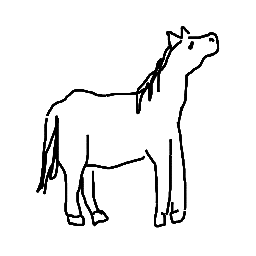

Final Caption

Sample 1: image of horse standing with no outline style drawn by person

Best Caption

Sample 1: image of horse standing near no solid line drawing free icon



In [29]:
# @title Output
Image.open(img_path).show()
print("Final Caption\n")
for i in range(len(FinalCaption)):
    print(f"{FinalCaption[i]}\n")
print("Best Caption\n")
for i in range(len(BestCaption)):
    print(f"{BestCaption[i]}\n")

## Dense Captioning

### SAM (하다가 실패함..)

In [ ]:
torch.cuda.memory_allocated()

13141457408

In [ ]:
del model

In [ ]:
!pip install transformers

In [ ]:
!pip install ipympl
from google.colab import output
output.enable_custom_widget_manager()

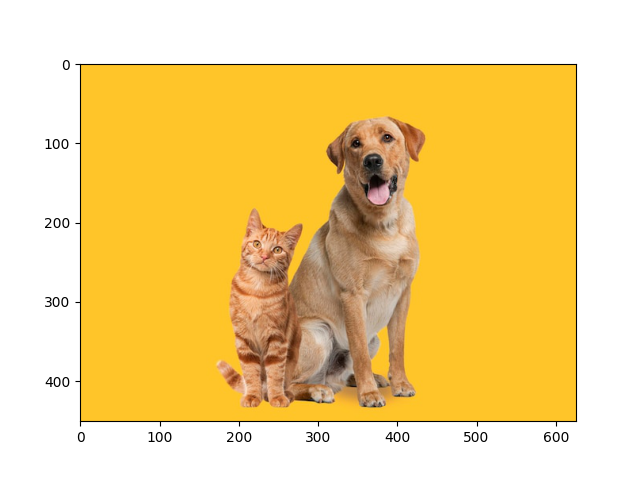

In [ ]:
%matplotlib ipympl
import matplotlib
from PIL import Image
import matplotlib.pyplot as plt
import torch

import requests
from transformers import SamModel, SamProcessor
import gc

fig, ax = plt.subplots()

def onclick(event):
    ix, iy = event.xdata, event.ydata
    print(ix, iy)

img_url = "https://img.freepik.com/premium-photo/labrador-retriever-dog-panting-ginger-cat-sitting-front-dark-yellow-background_191971-28714.jpg"
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert("RGB")


cid = fig.canvas.mpl_connect('button_press_event', onclick)

imgplot = plt.imshow(raw_image)
plt.show()

In [ ]:

gc.collect()
torch.cuda.empty_cache()

device = "cuda" if torch.cuda.is_available() else "cpu"
model = SamModel.from_pretrained("facebook/sam-vit-base").to(device)
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

input_points = [[[347.8673945703814, 263.6954603379773], [227.9682010219943, 311.6551377573321]]]  # 2D location of a window in the image

inputs = processor(raw_image, input_points=input_points, return_tensors="pt").to(device)
outputs = model(**inputs)

masks = processor.image_processor.post_process_masks(
    outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu()
)
scores = outputs.iou_scores
del outputs, inputs


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def crop_mask(image, mask):
  mask = mask.numpy()
  nonzero_coords = np.argwhere(mask)
  try:
    min_row, min_col = np.min(nonzero_coords, axis=0)
    max_row, max_col = np.max(nonzero_coords, axis=0) 
    print((min_col, min_row, max_col, max_row))
  except:
    return None
  cropped_image = raw_image.crop((min_col, min_row, max_col, max_row))
  return cropped_image


In [ ]:
from transformers import ViltProcessor, ViltForMaskedLM, AutoModelForMaskedLM, AutoTokenizer

import gc
gc.collect()
torch.cuda.empty_cache()

multimodal_model = ViltForMaskedLM.from_pretrained("dandelin/vilt-b32-mlm")
multimodal_processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-mlm")
model = multimodal_model.to(args.device)
processor = multimodal_processor
model_type = "ViLT"
multimodal_model.eval()


clip = CLIP(args.match_model)
clip.eval()
clip = clip.to(args.device)

DEBUG:urllib3.connectionpool:Resetting dropped connection: huggingface.co
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /dandelin/vilt-b32-mlm/resolve/main/config.json HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /dandelin/vilt-b32-mlm/resolve/main/preprocessor_config.json HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /dandelin/vilt-b32-mlm/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /openai/clip-vit-base-patch32/resolve/main/config.json HTTP/1.1" 200 0


Initializing CLIP model...


DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /openai/clip-vit-base-patch32/resolve/main/preprocessor_config.json HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /openai/clip-vit-base-patch32/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /openai/clip-vit-base-patch32/resolve/main/vocab.json HTTP/1.1" 200 0


CLIP model initialized.


### functions for Dense Captioning

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
import random
from utils import get_init_text, update_token_mask
import time


def generate_step(out, gen_idx, temperature=None, top_k=0, sample=False, return_list=True):
    """ Generate a word from out[gen_idx]

    args:
        - out (torch.Tensor): tensor of logits of size batch_size x seq_len x vocab_size
        - gen_idx (int): location for which to generate for
        - top_k (int): if >0, only sample from the top k most probable words
        - sample (Bool): if True, sample from full distribution. Overridden by top_k
    """
    logits = out[:, gen_idx]
    if temperature is not None:
        logits = logits / temperature
    if top_k > 0:
        kth_vals, kth_idx = logits.topk(top_k, dim=-1)
        dist = torch.distributions.categorical.Categorical(logits=kth_vals)
        idx = kth_idx.gather(dim=1, index=dist.sample().unsqueeze(-1)).squeeze(-1)
    elif sample:
        dist = torch.distributions.categorical.Categorical(logits=logits)
        idx = dist.sample().squeeze(-1)
    else:
        idx = torch.argmax(logits, dim=-1)
    return idx.tolist() if return_list else idx


def generate_caption_step(out, gen_idx, mask, temperature=None, top_k=100):
    # out, gen_idx=seed_len + ii, mask=token_mask, top_k=top_k, temperature=temperature
    """ Generate a word from out[gen_idx]
    args:
        - out (torch.Tensor): tensor of logits of size (batch_size, seq_len, vocab_size)
        - gen_idx (int): location for which to generate for
        - mask (torch.Tensor): (1, vocab_size)
        - top_k (int): candidate k
    """
    logits = out[:, gen_idx]
    if temperature is not None:
        logits = logits / temperature
    probs = F.softmax(logits, dim=-1)
    probs *= (mask)
    top_k_probs, top_k_ids = probs.topk(top_k, dim=-1)

    return top_k_probs, top_k_ids

def general_generation(generate_order, model_type, img_name,  model, clip, processor, image_instance, token_mask, prompt, logger, cropped_image,
                          max_len=15, span_len=None, top_k=100, temperature=None, alpha=0.7, beta=1,
                          max_iters=20, batch_size=1, verbose=True,):
    """ Generate one word at a time, in L->R order """
    print
    if model_type == "ViLT":
        tokenizer = processor.tokenizer
        pixel = processor.image_processor.preprocess(cropped_image, return_tensors="pt").pixel_values.to("cuda")
    else:
        tokenizer = processor

    seed_len = len(prompt.split()) + 1
    batch = get_init_text(tokenizer, prompt, max_len, batch_size)
    # if cropped_image is not None:
    #     image_embeds = clip.compute_image_representation_from_image_instance(cropped_image)
    # else:
    #     image_embeds = clip.compute_image_representation_from_image_instance(image_instance)
    image_embeds = clip.compute_image_representation_from_image_instance(image_instance).to("cuda")
    clip_score_sequence = []
    best_clip_score_list = [0] * batch_size
    best_caption_list = ['None'] * batch_size
    inp = torch.tensor(batch).to(image_embeds.device)
    gen_texts_list = []

    print(inp.device, image_embeds.device, pixel.device) 
    index_list = list(range(max_len))
    if generate_order == "shuffle":
        random.shuffle(index_list)

    for iter_num in range(max_iters):
        if generate_order != "span":
            for ii in index_list:
                if generate_order == "random":
                    ii = np.random.randint(0, max_len)
                token_mask = update_token_mask(tokenizer, token_mask, max_len, ii)
                inp[:, seed_len + ii] = tokenizer.mask_token_id
                inp_ = inp.clone().detach()

                if model_type != "ViLT":
                    out = model(input_ids=inp).logits
                else:
                    out = model(input_ids=inp, pixel_values = pixel).logits


                probs, idxs = generate_caption_step(out, gen_idx=seed_len + ii, mask=token_mask, top_k=top_k,
                                                    temperature=temperature)
                topk_inp = inp_.unsqueeze(1).repeat(1, top_k, 1)
                idxs_ = (idxs * token_mask[0][idxs]).long()
                topk_inp[:, :, ii + seed_len] = idxs_
                topk_inp_batch = topk_inp.view(-1, topk_inp.shape[-1])
                batch_text_list = tokenizer.batch_decode(topk_inp_batch, skip_special_tokens=True)
                clip_score, clip_ref = clip.compute_image_text_similarity_via_raw_text(image_embeds, batch_text_list)
                final_score = alpha * probs + beta * clip_score
                best_clip_id = final_score.argmax(dim=1).view(-1, 1)
                inp[:, seed_len + ii] = idxs_.gather(1, best_clip_id).squeeze(-1)
                current_clip_score = clip_ref.gather(1, best_clip_id).squeeze(-1)
                clip_score_sequence_batch = current_clip_score.cpu().detach().numpy().tolist()

        elif generate_order == "parallel":
            for kk in range(max_len):
                probs, idxs = generate_caption_step(out, gen_idx=seed_len + kk, mask=token_mask, top_k=top_k,
                                                    temperature=temperature)
                clip_score_sequence_batch = []
                for jj in range(batch_size):
                    topk_inp = inp_.unsqueeze(0).repeat(top_k, 1, 1)
                    topk_inp[:, jj, ii + seed_len] = (idxs[jj] * token_mask[0][idxs[jj]]).long()
                    batch_text_list = tokenizer.batch_decode(topk_inp[:, jj, :], skip_special_tokens=True)
                    single_image_embeds = image_embeds[jj].unsqueeze(0)
                    clip_score, clip_ref = clip.compute_image_text_similarity_via_raw_text(single_image_embeds,
                                                                                           batch_text_list)
                    final_score = alpha * probs[jj, :] + beta * clip_score
                    best_clip_id = final_score.argmax()
                    inp[jj][seed_len + kk] = idxs[jj][best_clip_id]
                    current_clip_score = clip_ref[0][best_clip_id]
                    clip_score_sequence_batch.append(current_clip_score.cpu().item())
        else:
            for span_start in range(0, max_len, span_len):
                span_end = min(span_start + span_len, max_len)
                inp[:, seed_len + span_start: seed_len + span_end] = tokenizer.mask_token_id
                out = model(input_ids=inp, pixel_values=pixel).logits
                for ii in range(span_start, span_end):
                    token_mask = update_token_mask(tokenizer, token_mask, max_len, ii)
                    inp_ = inp.clone().detach()
                    probs, idxs = generate_caption_step(out, gen_idx=seed_len + ii, mask=token_mask, top_k=top_k,
                                                        temperature=temperature)
                    topk_inp = inp_.unsqueeze(1).repeat(1, top_k, 1)
                    idxs_ = (idxs * token_mask[0][idxs]).long()
                    topk_inp[:, :, ii + seed_len] = idxs_
                    topk_inp_batch = topk_inp.view(-1, topk_inp.shape[-1])
                    batch_text_list = tokenizer.batch_decode(topk_inp_batch, skip_special_tokens=True)
                    clip_score, clip_ref = clip.compute_image_text_similarity_via_raw_text(image_embeds,
                                                                                           batch_text_list)
                    final_score = alpha * probs + beta * clip_score
                    best_clip_id = final_score.argmax(dim=1).view(-1, 1)
                    inp[:, seed_len + ii] = idxs_.gather(1, best_clip_id).squeeze(-1)
                    current_clip_score = clip_ref.gather(1, best_clip_id).squeeze(-1)
                    clip_score_sequence_batch = current_clip_score.cpu().detach().numpy().tolist()

        if verbose and np.mod(iter_num + 1, 1) == 0:
            for_print_batch = tokenizer.batch_decode(inp)
            cur_text_batch = tokenizer.batch_decode(inp, skip_special_tokens=True)
            for jj in range(batch_size):
                if best_clip_score_list[jj] < clip_score_sequence_batch[jj]:
                    best_clip_score_list[jj] = clip_score_sequence_batch[jj]
                    best_caption_list[jj] = cur_text_batch[jj]
                logger.info(f"iter {iter_num + 1}, The {jj + 1}-th image: {img_name[jj]},"
                            f"clip score {clip_score_sequence_batch[jj]:.3f}: " + for_print_batch[jj])
        gen_texts_list.append(cur_text_batch)
        clip_score_sequence.append(clip_score_sequence_batch)
    gen_texts_list.append(best_caption_list)
    clip_score_sequence.append(best_clip_score_list)

    return gen_texts_list, clip_score_sequence


def generate_caption(img_name, model_type, model, clip, tokenizer, image_instance, token_mask, logger, cropped_image,
                     prompt="", batch_size=1, max_len=15,
                     top_k=100, temperature=1.0, max_iter=500, alpha=0.7, beta=1,
                     generate_order="sequential" ):
    # main generation functions to call
    start_time = time.time()

    generate_texts, clip_scores = general_generation(generate_order, model_type, img_name, model, clip, tokenizer, image_instance,
                                                        token_mask, prompt, logger, cropped_image,
                                                        batch_size=batch_size, max_len=max_len, top_k=top_k,
                                                        alpha=alpha, beta=beta, temperature=temperature,
                                                        max_iters=max_iter,)

    logger.info("Finished in %.3fs" % (time.time() - start_time))


    final_caption = generate_texts[-2]
    best_caption = generate_texts[-1]
    for i in range(batch_size):
        logger.info(f"The {i + 1}-th image: {img_name[i]}")
        logger.info(f"final caption: {final_caption[i]}")
        logger.info(f"best caption: {best_caption[i]}")
    return generate_texts, clip_scores


In [ ]:
def run_cropped_caption(args, lm_model, lm_tokenizer, clip, token_mask, logger, model_type, prompt, cropped_image, image_instance = None, image_path = None):
    FinalCaptionList = []
    BestCaptionList = []
    if image_path is not None:
      logger.info(f"Processing: {image_path}")
      image_instance = Image.open(image_path).convert("RGB")
      img_name = [image_path.split("/")[-1]]
    else:
      image_path="제발"
    for sample_id in range(args.samples_num):
        logger.info(f"Sample {sample_id}: ")
        gen_texts, clip_scores = generate_caption(generate_order=args.order, 
                                                  model_type=model_type, 
                                                  img_name=image_path, 
                                                  model=lm_model, 
                                                  clip=clip, 
                                                  tokenizer=lm_tokenizer, 
                                                  image_instance=image_instance, 
                                                  token_mask=token_mask, 
                                                  prompt=prompt, 
                                                  logger=logger,
                                                  cropped_image=cropped_image,
                                                  batch_size=args.batch_size, 
                                                  max_len=args.sentence_len,
                                                  top_k=args.candidate_k,
                                                  temperature=args.lm_temperature,
                                                  max_iter=args.num_iterations,
                                                  alpha=args.alpha,
                                                  beta=args.beta,
                                                  )
        
        
        FinalCaptionStr = "Sample {}: ".format(sample_id + 1) + gen_texts[-2][0]
        BestCaptionStr = "Sample {}: ".format(sample_id + 1) + gen_texts[-1][0]
        FinalCaptionList.append(FinalCaptionStr)
        BestCaptionList.append(BestCaptionStr)
    return FinalCaptionList, BestCaptionList   
def stopandmask(tokenizer, model_type):
  if model_type == "ViLT":
    tokenizer = tokenizer.tokenizer
  with open(args.stop_words_path,'r',encoding='utf-8') as stop_words_file:
      stop_words = stop_words_file.readlines()
      stop_words_ = [stop_word.rstrip('\n') for stop_word in stop_words]
      stop_words_ += args.add_extra_stopwords
      stop_ids = tokenizer.convert_tokens_to_ids(stop_words_)
      token_mask = torch.ones((1,tokenizer.vocab_size))
      for stop_id in stop_ids:
          token_mask[0,stop_id]=0
      token_mask = token_mask.to(args.device)
  return stop_words, stop_ids, token_mask

In [ ]:
import numpy as np

example_name = 'orig.png'
example_img_path = os.path.join(os.getcwd(),"examples", example_name)

cropped = 'cat.png'
cropped_img_path = os.path.join(os.getcwd(),"examples", cropped)

crop = Image.open(cropped_img_path).convert("RGB")
crop = np.array(crop)

raw_image = Image.open(example_img_path).convert("RGB")
raw_image = np.array(raw_image)

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'sRGB' 41 1
DEBUG:PIL.PngImagePlugin:STREAM b'gAMA' 54 4
DEBUG:PIL.PngImagePlugin:STREAM b'pHYs' 70 9
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 91 65445
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'sRGB' 41 1
DEBUG:PIL.PngImagePlugin:STREAM b'gAMA' 54 4
DEBUG:PIL.PngImagePlugin:STREAM b'pHYs' 70 9
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 91 65445


In [ ]:
# @title Run Dense Captioning 
import gc
gc.collect()
torch.cuda.empty_cache()

# @title Image captioning


args.alpha = 0.2
args.beta = 2
args.num_iterations = 20


stop_words, stop_ids, token_mask = stopandmask(processor, model_type)

args.candidate_k = 10
FinalCaption, BestCaption = run_cropped_caption(args=args, 
                                                lm_model=model, 
                                                lm_tokenizer=processor, 
                                                clip=clip, 
                                                token_mask=token_mask, 
                                                logger=logger, 
                                                model_type=model_type, 
                                                cropped_image=crop, 
                                                prompt = "image of a",
                                                image_instance=raw_image ,
                                                image_path=None) 

Sample 0: 
INFO:ConZIC:Sample 0: 


cuda:0 cuda:0 cuda:0


iter 1, The 1-th image: 제,clip score 0.317: [CLS] image of a cat and an in the middle with the left paw [SEP]
INFO:ConZIC:iter 1, The 1-th image: 제,clip score 0.317: [CLS] image of a cat and an in the middle with the left paw [SEP]
iter 2, The 1-th image: 제,clip score 0.380: [CLS] image of a cat and dog in white background on front left side [SEP]
INFO:ConZIC:iter 2, The 1-th image: 제,clip score 0.380: [CLS] image of a cat and dog in white background on front left side [SEP]
iter 3, The 1-th image: 제,clip score 0.379: [CLS] image of a cat and dog against white background standing front to right [SEP]
INFO:ConZIC:iter 3, The 1-th image: 제,clip score 0.379: [CLS] image of a cat and dog against white background standing front to right [SEP]
iter 4, The 1-th image: 제,clip score 0.397: [CLS] image of a cat and puppy and white background left facing to right [SEP]
INFO:ConZIC:iter 4, The 1-th image: 제,clip score 0.397: [CLS] image of a cat and puppy and white background left facing to right 